In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.nonparametric.smoothers_lowess import lowess
import seaborn
from pykalman import KalmanFilter
seaborn.set()

In [2]:
data = pd.read_csv("agg-data.csv")
data["time"] = pd.to_datetime(data["time"], utc=True)
data

,time,latitude,longitude,ax,ay,az,atotal,wx,wy,wz,type
0,2022-12-07 13:25:56+00:00,49.265058,-123.179879,-0.470800,0.739200,-0.371200,2.361800,1.17,0.19,2.27,hand
1,2022-12-07 13:25:57+00:00,49.265051,-123.179900,0.598100,0.351900,0.261800,2.137800,1.35,0.29,2.50,hand
2,2022-12-07 13:25:58+00:00,49.265067,-123.179909,0.139600,-0.098200,0.221800,2.529400,1.47,0.32,2.73,hand
3,2022-12-07 13:25:59+00:00,49.265078,-123.179908,0.230396,-0.053762,0.241188,2.847921,1.54,0.32,2.94,hand
4,2022-12-07 13:26:00+00:00,49.265094,-123.179896,1.004818,-1.018091,0.129727,3.999727,1.57,0.25,3.11,hand
...,...,...,...,...,...,...,...,...,...,...,...
284,2022-12-07 13:30:42+00:00,49.265123,-123.179463,2.804900,-2.715900,0.007700,7.546000,-1.04,0.38,-3.36,hand
285,2022-12-07 13:30:43+00:00,49.265116,-123.179458,3.678387,-3.106129,-0.457957,9.290968,-0.85,0.35,-3.11,hand
286,2022-12-07 13:30:44+00:00,49.265106,-123.179469,3.357629,-1.264124,-0.243608,7.064124,-0.66,0.33,-2.84,hand
287,2022-12-07 13:30:45+00:00,49.265104,-123.179470,1.974516,-0.504194,-0.149032,5.620753,-0.45,0.29,-2.58,hand


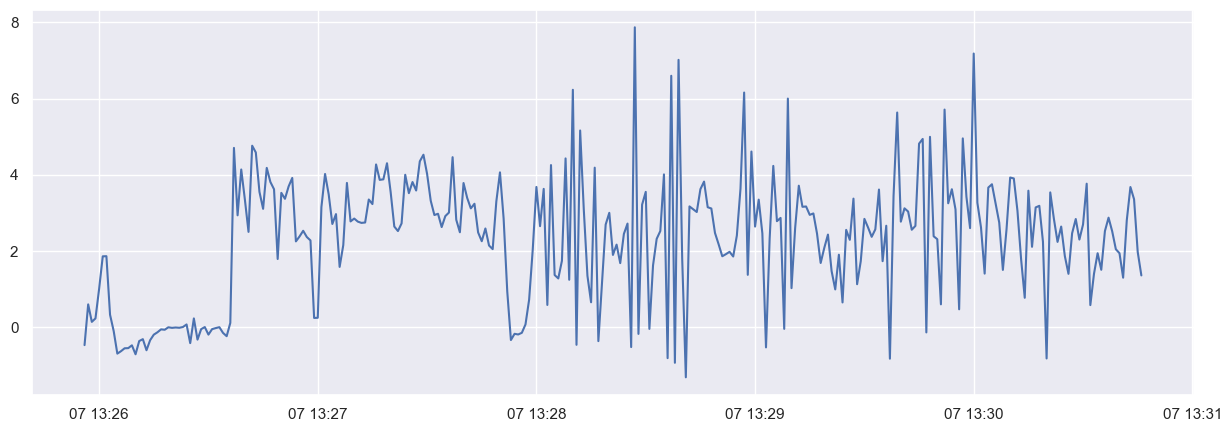

In [3]:
plt.figure(figsize=(15,5))
plt.plot(data["time"], data["ax"])

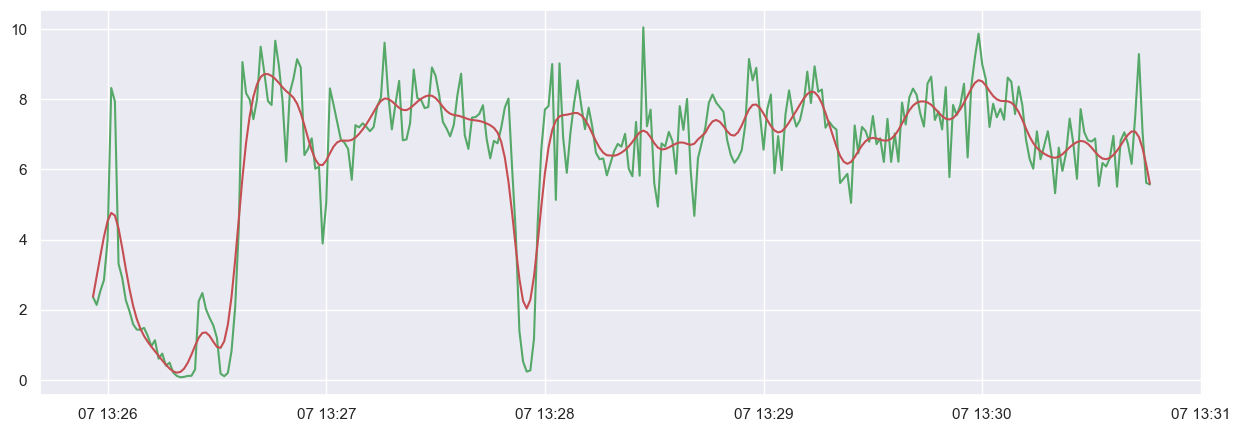

In [4]:
b, a = signal.butter(2, 0.15, btype='lowpass', analog=False)
low_pass = signal.filtfilt(b, a, data["atotal"])
plt.figure(figsize=(15,5))
plt.plot(data["time"], data["atotal"], "g-")
plt.plot(data["time"], low_pass, "r-")

In [5]:
def smooth(kalman_data):
    initial_state = kalman_data.iloc[0]
    observation_covariance = np.diag([0.00005, 0.00005, 0, 0]) ** 2 
    transition_covariance = np.diag([0.00005, 0.00005, 0, 0]) ** 2 
    transition = [
        [1, 0, 6*(10**-7), 29*(10**-7)], 
        [0, 1, -43*(10**-7), 12*(10**-7)], 
        [0, 0, 1, 0], 
        [0, 0, 0, 1]]
    kf = KalmanFilter(
        initial_state_mean=initial_state,
        initial_state_covariance=observation_covariance,
        observation_covariance=observation_covariance,
        transition_covariance=transition_covariance,
        transition_matrices=transition
      )
    kalman_smoothed, _ = kf.smooth(kalman_data)
    results = kalman_data
    results['lat'] = kalman_smoothed[:,0]
    results['lon'] = kalman_smoothed[:,1]
    return results

In [6]:
res = data.set_index("time")[["latitude", "longitude", "wx", "wy"]]
smoothed_data = smooth(res).reset_index()

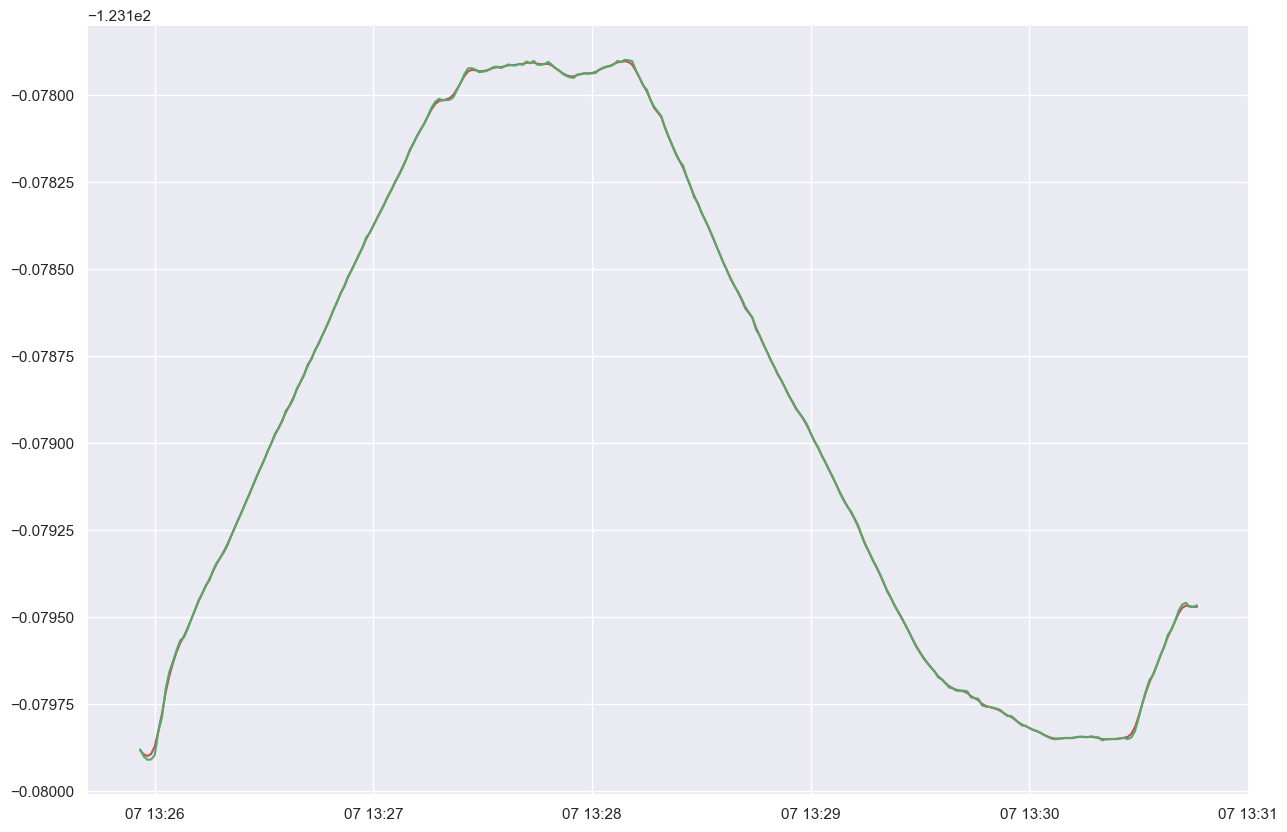

In [7]:
data["longitude"] = smoothed_data["lon"]
data["latitude"] = smoothed_data["lat"]
plt.figure(figsize=(15,10))
plt.plot(data["time"], data["longitude"], "r-")
plt.plot(smoothed_data["time"], smoothed_data["longitude"], "g-")